In [1]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
train_feats = pa.read_csv('win_train_feats.csv')
train_targets = pa.read_csv('win_train_targets.csv')
val_feats = pa.read_csv('win_validation_feats.csv')
val_targets = pa.read_csv('win_validation_targets.csv')
vval_feats = pa.read_csv('win_val_train_feats.csv')
vval_targets = pa.read_csv('win_val_train_targets.csv')

In [3]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.float32)
ty = np.asarray(train_targets['LABEL'], dtype=np.float32).reshape(-1, 1)
vx = np.asarray(val_feats, dtype=np.float32)
vyall = np.asarray(val_targets, dtype=np.float32)
vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [4]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [5]:
ty = ty.ravel()
vy = vy.ravel()

In [6]:
print tx.shape, tyall.shape, ty.shape, vx.shape, vyall.shape, vy.shape, valx.shape

(481571, 321) (481571, 4) (481571,) (146866, 321) (146866, 4) (146866,) (199971, 321)


In [7]:
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc_score

In [35]:
clf = svm.SVC(verbose=True, max_iter=400, class_weight={0:1, 1:2})
clf.fit(tx, ty)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=400, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=True)

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, verbose=True, n_jobs=5, max_depth=3)
clf.fit(tx, ty)

[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:  2.0min remaining:  8.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.1min finished


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=500, n_jobs=5,
            oob_score=False, random_state=None, verbose=True)

In [10]:
tprobs = clf.decision_function(tx)
vprobs = clf.decision_function(vx)
valprobs = clf.decision_function(valx)

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [49]:
tprobs = clf.predict_proba(tx)[:,1]
vprobs = clf.predict_proba(vx)[:,1]
valprobs = clf.predict_proba(valx)[:,1]

[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    3.4s remaining:   13.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    1.1s remaining:    4.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    1.5s remaining:    5.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.5s finished


In [19]:
print tprobs

[ 0.03918062  0.05856521  0.05856521 ...,  0.02660812  0.02660812
  0.02660812]


0.974553220167


/home/du2/12CS30009/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


0.977126378314


/home/du2/12CS30009/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


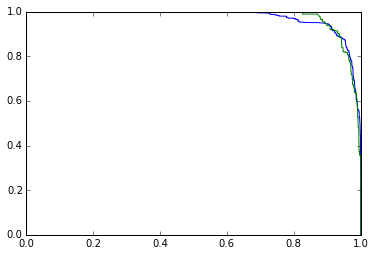

In [50]:
yscore = tprobs.ravel()
fpr, tpr, thresh = roc_curve(ty, yscore)
auc = auc_score(ty, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

yscore = vprobs.ravel()
fpr, tpr, thresh = roc_curve(vy, yscore)
auc = auc_score(vy, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

In [45]:
# thresh = np.percentile(vprobs.ravel(), 98.5)
thresh = 0.406092323258
print thresh
pred = np.int32(vprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(vx.shape[0]):
    if np.int32(vyall[i,3]) == 1.0:
        outfile.write(str(vyall[i,0])+','+str(vyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

0.406092323258
8151


In [26]:
# for i in vprobs[np.where(vprobs.ravel()>=thresh)]:
#     print i

In [51]:
thresh = np.percentile(valprobs.ravel(), 99.3)
# thresh = 0.80
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
outfile.close()

0.38117361412
1411


In [46]:
reload(V)
V.validate('out.csv', './Training_Dataset/id_label_train.csv')

tp :  29 , tn :  809 , fp :  5 , fn :  27
sensitivity :  0.517857142857 , specificity :  0.993857493857
accuracy :  0.963218390805 median prediction time :  37.5416666667
finalScore :  51.1962733838


(0.5178571428571429,
 0.9938574938574939,
 0.9632183908045977,
 37.541666666666664,
 51.1962733837734)